In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import json
import pickle
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from scipy.stats import randint as sp_randint
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SequentialFeatureSelector

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        total = []
        for row in cm:
          s = np.sum(row)
          total.append(s)

        print("Total number of samples for each classs: " + str(total))

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [3]:
# Retrieve the target based on the directoie
SOUND_FOLDER = "./Audio_Dataset"
FEAT_FOLDER = "./Features"

### **Data Preparation**

In [4]:
# Load features
path = os.path.join(FEAT_FOLDER+"/feature.pkl")
df_features = pd.read_pickle(path)

# Load target
path = os.path.join(SOUND_FOLDER+"/label.csv")
df_labels = pd.read_csv(path)

In [5]:
print(df_labels['class'].value_counts(dropna=False).index.values)
print(list(df_features.columns))

['kick' 'snare' 'overheads' 'toms']
['file_name', 'path', 'SC_mean', 'SBW_mean', 'MFCC_mean_0', 'MFCC_mean_1', 'MFCC_mean_2', 'MFCC_mean_3', 'MFCC_mean_4', 'MFCC_mean_5', 'MFCC_mean_6', 'MFCC_mean_7', 'MFCC_mean_8', 'MFCC_mean_9', 'MFCC_mean_10', 'MFCC_mean_11', 'MFCC_mean_12', 'Contrast_mean0', 'Contrast_mean1', 'Contrast_mean2', 'Contrast_mean3', 'Contrast_mean4', 'Contrast_mean5', 'Contrast_mean6']


In [7]:
# Merge features and label dataframes
feat_df = df_features.merge(df_labels, how='inner', on=['path', 'file_name'])

In [8]:
X = feat_df.drop(["path",'file_name', 'class'], axis= 1).to_numpy()
Y = feat_df["class"].to_numpy()

In [11]:
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
print(Y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3]


In [12]:
# Data Normalization
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

print(np.shape(X_train))
print(np.shape(Y_train))
print(np.shape(X_test))
print(np.shape(Y_test))



(136, 22)
(136,)
(24, 22)
(24,)


In [13]:
# Build the classification model
model = tf.keras.models.Sequential([tf.keras.layers.Dense(256, activation=tf.nn.relu, input_shape=(X_train.shape[1],)),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(4, activation=tf.nn.softmax)])

In [19]:
model.compile(optimizer = tf.optimizers.legacy.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=100)


Epoch 1/20
5/5 [==============================] - 0s 1ms/step - loss: 0.6336 - accuracy: 0.9412
Epoch 2/20
5/5 [==============================] - 0s 955us/step - loss: 0.5445 - accuracy: 0.9338
Epoch 3/20
5/5 [==============================] - 0s 844us/step - loss: 0.4626 - accuracy: 0.9559
Epoch 4/20
5/5 [==============================] - 0s 817us/step - loss: 0.3970 - accuracy: 0.9412
Epoch 5/20
5/5 [==============================] - 0s 868us/step - loss: 0.3387 - accuracy: 0.9706
Epoch 6/20
5/5 [==============================] - 0s 897us/step - loss: 0.2931 - accuracy: 0.9412
Epoch 7/20
5/5 [==============================] - 0s 821us/step - loss: 0.2454 - accuracy: 0.9632
Epoch 8/20
5/5 [==============================] - 0s 831us/step - loss: 0.2256 - accuracy: 0.9706
Epoch 9/20
5/5 [==============================] - 0s 761us/step - loss: 0.1936 - accuracy: 0.9706
Epoch 10/20
5/5 [==============================] - 0s 729us/step - loss: 0.1687 - accuracy: 0.9779
Epoch 11/20
5/5 [====

In [15]:
# Evaluate the model on unseen data
model.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 72ms/step - loss: 0.5968 - accuracy: 0.9167


[0.5968199372291565, 0.9166666865348816]

In [16]:
classes = df_labels['class'].value_counts(dropna=False).index.values
classifications = model.predict(X_test)
print(classes)

1/1 [==============================] - 0s 40ms/step
['kick' 'snare' 'overheads' 'toms']


In [17]:
print(classifications)
print(Y_test)
Y_test_pred = np.argmax(classifications, axis=1)
print(Y_test_pred)

[[0.02914379 0.8665306  0.07851993 0.02580562]
 [0.01743984 0.920032   0.04817194 0.01435616]
 [0.28145128 0.03071101 0.23376578 0.4540719 ]
 [0.1994471  0.06976857 0.33675    0.39403433]
 [0.08736102 0.5279038  0.2463069  0.1384283 ]
 [0.53306    0.0453268  0.14874916 0.27286398]
 [0.03714916 0.85717064 0.07486728 0.03081291]
 [0.13335317 0.1669441  0.48315898 0.21654376]
 [0.03050423 0.8553644  0.08654104 0.02759033]
 [0.24272172 0.02738698 0.23646232 0.493429  ]
 [0.48981705 0.0776581  0.18579224 0.24673256]
 [0.00920043 0.9424272  0.03991994 0.00845232]
 [0.46018705 0.09695095 0.19717629 0.2456857 ]
 [0.16852574 0.1429371  0.42493242 0.26360473]
 [0.5552983  0.05195786 0.15537229 0.23737153]
 [0.55504453 0.0527319  0.15275884 0.23946476]
 [0.22936292 0.04415437 0.2380044  0.48847827]
 [0.17091642 0.02878421 0.30400655 0.49629274]
 [0.03221685 0.8936986  0.0547994  0.0192852 ]
 [0.46694973 0.05926196 0.18544288 0.28834546]
 [0.09766116 0.34590045 0.451298   0.10514034]
 [0.4533336  

Normalized confusion matrix
Confusion matrix, without normalization
Total number of samples for each classs: [8, 7, 3, 6]


<Axes: title={'center': 'Classification Forest'}, xlabel='Predicted label', ylabel='True label'>

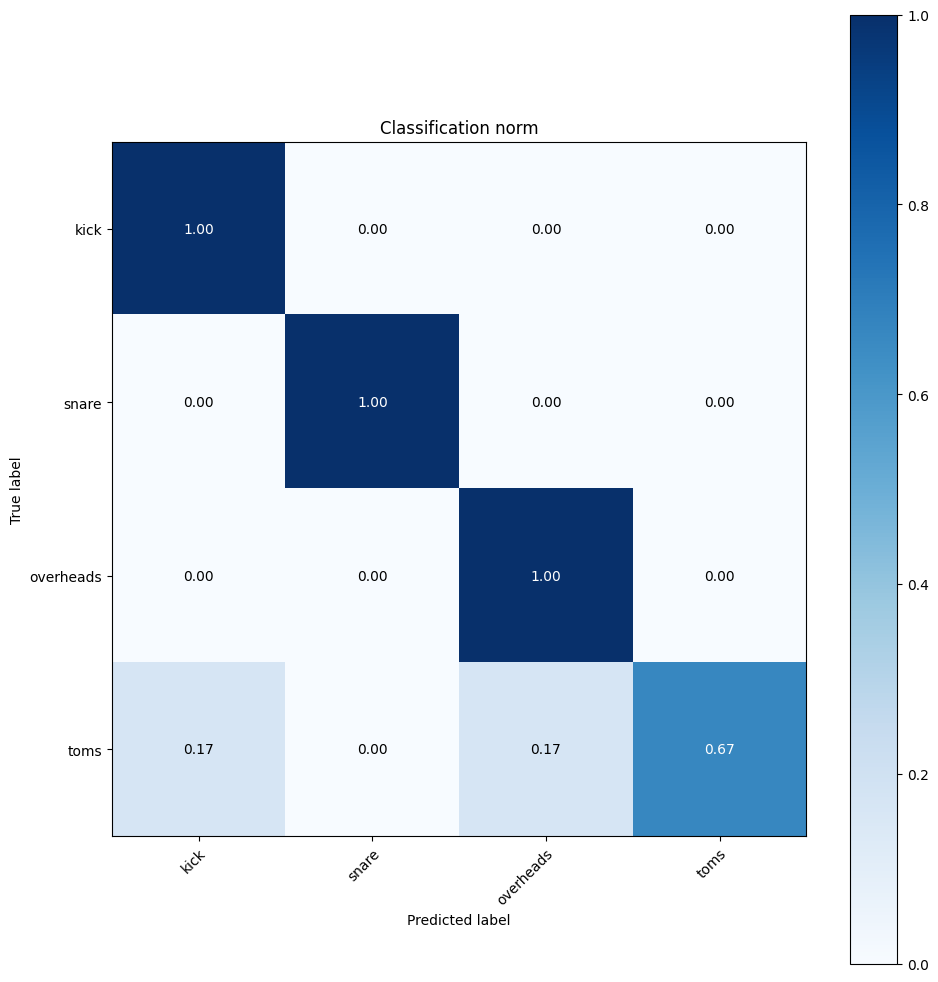

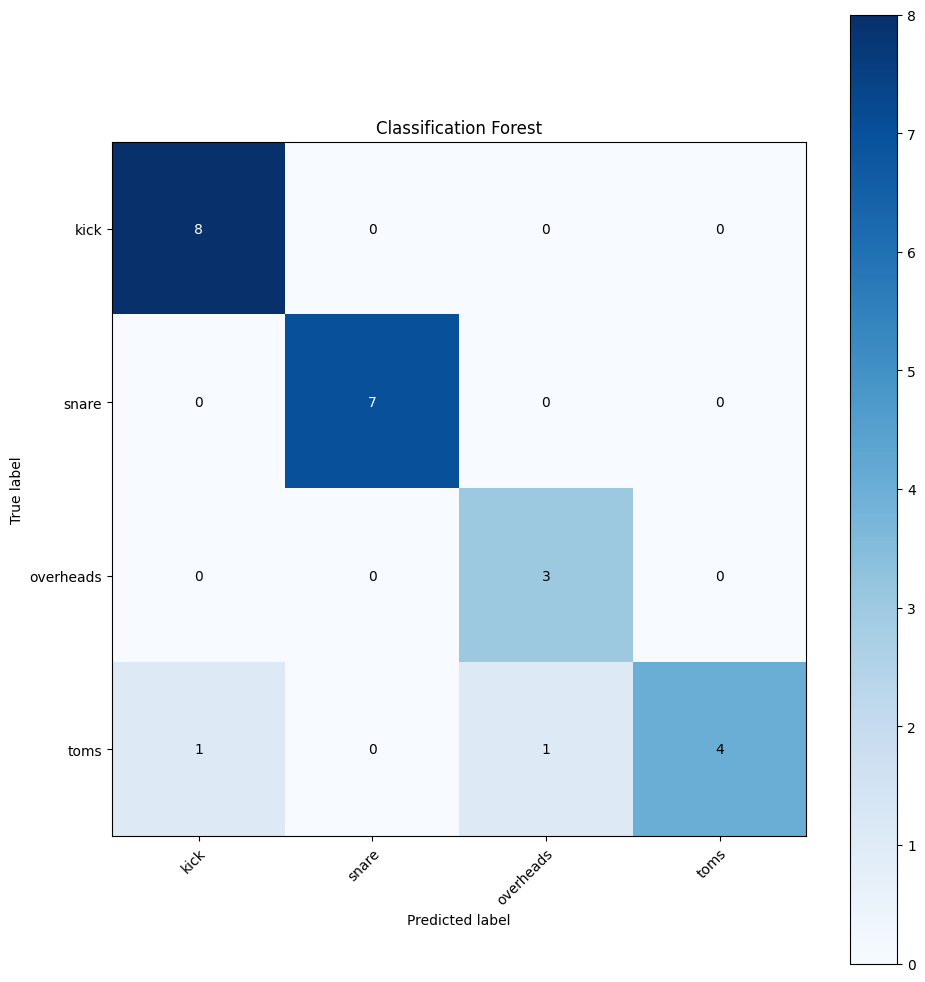

In [18]:
classes = df_labels['class'].value_counts(dropna=False).index.values

plot_confusion_matrix(Y_test_pred, Y_test, classes=df_labels['class'].value_counts(dropna=False).index.values, normalize=True, title='Classification norm')
plot_confusion_matrix(Y_test_pred, Y_test, classes=df_labels['class'].value_counts(dropna=False).index.values, normalize=False, title='Classification Forest')